In [1]:
import sys

import pandas as pd
import seaborn as sns
import numpy as np
import scipy.sparse as sp

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8

from scipy.stats import norm
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, CategoricalNB
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime

import category_encoders as ce

import warnings
warnings.filterwarnings('ignore')

import clean


In [ ]:
# sys.path.append("/content/drive/MyDrive/Project DS")

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import the training data
df = pd.read_csv('one_hot_dataset.csv')
# this dataset is cleaned through remove unneeded and prepare

In [3]:
pd.set_option('display.max_columns', None)

df

,blurb,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,category_11,category_12,category_13,category_14,category_15,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9,country_10,country_11,country_12,country_13,country_14,country_15,country_16,country_17,country_18,country_19,country_20,country_21,country_22,country_23,country_24,country_25,country_26,country_27,country_28,country_29,country_30,country_31,country_32,country_33,country_34,country_35,country_36,country_37,country_38,country_39,country_40,country_41,country_42,country_43,country_44,country_45,country_46,country_47,country_48,country_49,country_50,country_51,country_52,country_53,country_54,country_55,country_56,country_57,country_58,country_59,country_60,country_61,country_62,country_63,country_64,country_65,country_66,country_67,country_68,country_69,country_70,country_71,country_72,country_73,country_74,country_75,country_76,country_77,country_78,country_79,country_80,country_81,country_82,country_83,country_84,country_85,country_86,country_87,country_88,country_89,country_90,country_91,country_92,country_93,country_94,country_95,country_96,country_97,country_98,country_99,country_100,country_101,country_102,country_103,country_104,country_105,country_106,country_107,country_108,country_109,country_110,country_111,country_112,country_113,country_114,country_115,country_116,country_117,country_118,country_119,country_120,country_121,country_122,country_123,country_124,country_125,country_126,country_127,country_128,country_129,country_130,country_131,country_132,country_133,country_134,country_135,country_136,country_137,country_138,country_139,country_140,country_141,country_142,country_143,country_144,country_145,country_146,country_147,country_148,country_149,country_150,country_151,country_152,country_153,country_154,country_155,country_156,country_157,country_158,country_159,country_160,country_161,country_162,country_163,country_164,country_165,country_166,country_167,country_168,country_169,country_170,country_171,country_172,country_173,country_174,currency_1,currency_2,currency_3,currency_4,currency_5,currency_6,currency_7,currency_8,currency_9,currency_10,currency_11,currency_12,currency_13,currency_14,goal,name,staff_pick_1,staff_pick_2,funded,subcategory_1,subcategory_2,subcategory_3,subcategory_4,subcategory_5,subcategory_6,subcategory_7,subcategory_8,subcategory_9,subcategory_10,subcategory_11,subcategory_12,subcategory_13,subcategory_14,subcategory_15,subcategory_16,subcategory_17,subcategory_18,subcategory_19,subcategory_20,subcategory_21,subcategory_22,subcategory_23,subcategory_24,subcategory_25,subcategory_26,subcategory_27,subcategory_28,subcategory_29,subcategory_30,subcategory_31,subcategory_32,subcategory_33,subcategory_34,subcategory_35,subcategory_36,subcategory_37,subcategory_38,subcategory_39,subcategory_40,subcategory_41,subcategory_42,subcategory_43,subcategory_44,subcategory_45,subcategory_46,subcategory_47,subcategory_48,subcategory_49,subcategory_50,subcategory_51,subcategory_52,subcategory_53,subcategory_54,subcategory_55,subcategory_56,subcategory_57,subcategory_58,subcategory_59,subcategory_60,subcategory_61,subcategory_62,subcategory_63,subcategory_64,subcategory_65,subcategory_66,subcategory_67,subcategory_68,subcategory_69,subcategory_70,subcategory_71,subcategory_72,subcategory_73,subcategory_74,subcategory_75,subcategory_76,subcategory_77,subcategory_78,subcategory_79,subcategory_80,subcategory_81,subcategory_82,subcategory_83,subcategory_84,subcategory_85,subcategory_86,subcategory_87,subcategory_88,subcategory_89,subcategory_90,subcategory_91,subcategory_92,subcategory_93,subcategory_94,subcategory_95,subcategory_96,subcategory_97,subcategory_98,subcategory_99,subcategory_100,subcategory_101,subcategory_102,subcategory_103,subcategory_104,subcategory_105,subcategory_106,subcategory_107,subcategory_108,subcategory_109,subc

# Baseline Model

In [5]:
# the test data has 175 countries while the training data has 174, hence we add one extra category to the training data consisting of 0's
df['country_175'] = 0

In [6]:
# we scale the numerical data, i.e. we scale all of the numbers between 0 and 1
df_scaled = clean.scale_data(df, features=['blurb', 'sent_blurb', 'name', 'hbl', 'goal', 'funded'])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_scaled, df.funded, test_size=0.3)

In [ ]:
clf = MultinomialNB()

In [ ]:
clf.fit(x_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [12]:
def plot_roc(model, x, y, name='linear'):
    y_text = model.predict_proba(x)

    curve_linear = metrics.roc_curve(y, y_text[:, 1])

    # Compute AUC from the created ROC
    auc_linear = metrics.auc(curve_linear[0], curve_linear[1])

    plt.plot(curve_linear[0], curve_linear[1], label=f'{name} (area = %0.2f)' % auc_linear)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve');

    plt.legend();

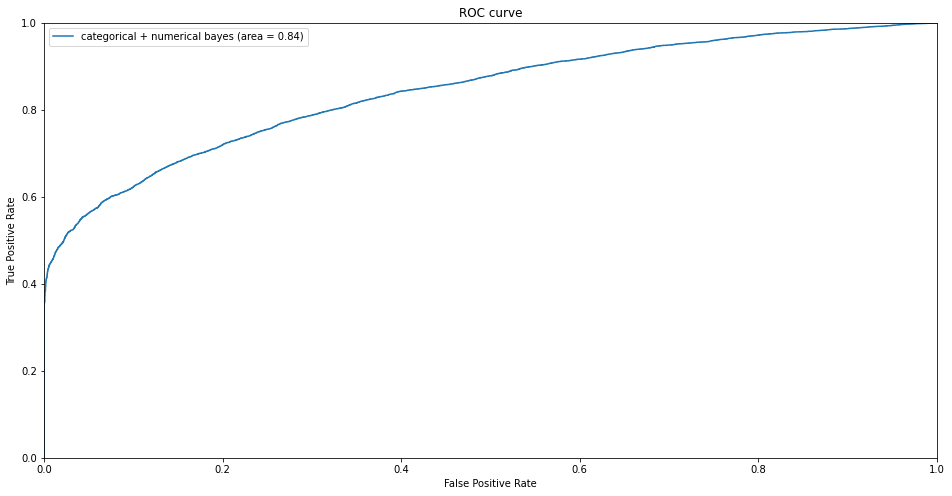

In [ ]:
plot_roc(clf, x_test, y_test, 'categorical + numerical bayes')

##### Cross-validation

In [ ]:
scores = cross_val_score(clf, df_scaled, df.funded, cv=5)
predicted = cross_val_predict(clf, df_scaled, df.funded, cv=5)
print(metrics.accuracy_score(df.funded, predicted))
print(scores.mean(), scores)
# scores: 0.7219899163698932 when cv=100

0.5784182305630027
0.578418949233272 [0.51923173 0.50332616 0.58920622 0.63007052 0.6502601 ]


In [ ]:
predicted = clf.predict(x_test)
metrics.accuracy_score(y_test, predicted)

0.753184394798266

# Random Forest Model

In [10]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10, random_state=0)

0.7738246082027342

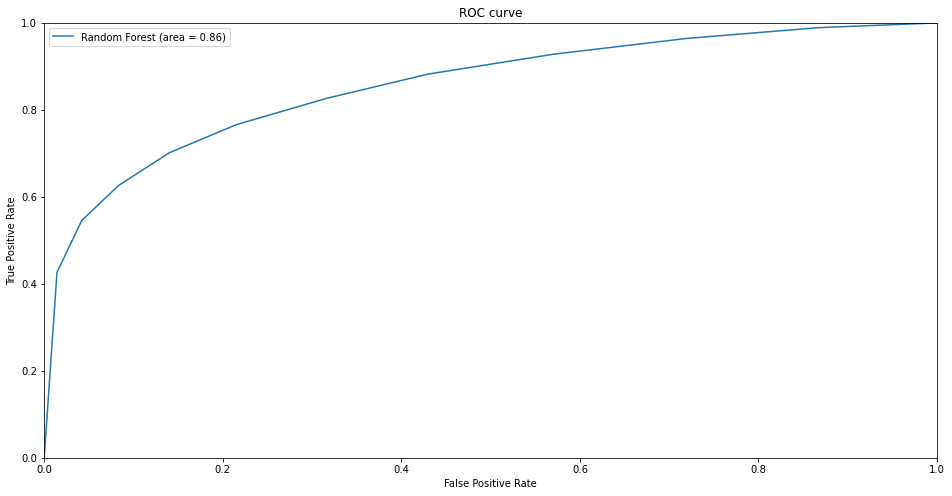

In [13]:
x_train, x_test, y_train, y_test = train_test_split(df_scaled, df.funded, test_size=0.3)
model.fit(x_train, y_train)
plot_roc(model, x_test, y_test, 'Random Forest')
predicted = model.predict(x_test)
metrics.accuracy_score(y_test, predicted)


In [18]:
scores = cross_val_score(model, df_scaled, df.funded, cv=5)
predicted = cross_val_predict(model, df_scaled, df.funded, cv=5)
print(metrics.accuracy_score(df.funded, predicted))
print(scores.mean(), scores)

0.6157916850066024
0.6157923830763737 [0.60651228 0.53553744 0.6205672  0.63077077 0.68557423]


### Hyper-parameters tuning using Grid Search:

In [ ]:
# Prepare parameters 
model.get_params()
#  Number of trees in random forst
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 110, num = 6)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

params = {'n_estimators': n_estimators,
          'max_features': max_features,
          'max_depth': max_depth,
          'min_samples_split': min_samples_split,
          'min_samples_leaf': min_samples_leaf,
          'bootstrap': bootstrap
          }

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
x_train, x_test, y_train, y_test = train_test_split(df_scaled, df.funded, test_size=0.3)
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = params, 
                               n_iter = 10, 
                               cv = 3, 
                               random_state=0)

In [ ]:
rf_random.fit(x_train, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

0.794864954984995

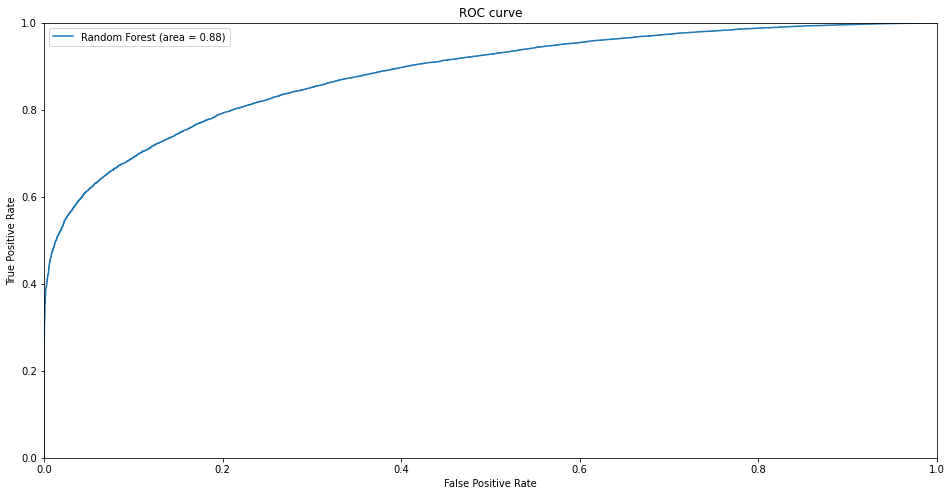

In [ ]:
plot_roc(rf_random, x_test, y_test, 'Random Forest')
predicted = rf_random.predict(x_test)
metrics.accuracy_score(y_test, predicted)

##### Cross-Validation

In [21]:
best_model = RandomForestClassifier(n_estimators=100, max_features='auto', max_depth=None, min_samples_leaf=1, min_samples_split=2, bootstrap=True )

In [22]:
scores = cross_val_score(best_model, df_scaled, df.funded, cv=10)
predicted = cross_val_predict(best_model, df_scaled, df.funded, cv=10)
print(metrics.accuracy_score(df.funded, predicted))
print(scores.mean(), scores)

0.5669240926733624
0.5726860735291416 [0.64549365 0.63178954 0.43783135 0.58497549 0.59103641 0.62164866
 0.62865146 0.57222889 0.54651861 0.46668667]


# Evaluation

In [ ]:
# df = pd.read_csv('one_hot_dataset.csv')
# df_test = pd.read_csv('clean_testset.csv')

In [ ]:
df_test = pd.read_csv('KS_test_data.csv', delimiter=';')

In [ ]:
df_test = clean.remove_unneeded(df_test, mode='test')
'''This bad boy:
        - fills country values that are missing with the mode
        - removes null values and empty strings from blurb AND NAME
        - removes numeric values from blurb AND NAME
        - drops uneeded columns/features
'''

In [ ]:
df_test = clean.prepare(df_test)
''' This bad boy:
    - adds log hbl # hours before launch
    - adds hbd # hourse before deadline
    - adds goal_usd => goal converted to usd
    - adds len_blurb => length of the blurb
    - adds sent_blurb = > sentiment analysis of blurb
    - one hot encodes the categorical features
'''
df_test
# pandas.set_option('display.max_columns', None)

,project_id,blurb,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,...,subcategory_153,subcategory_154,subcategory_155,subcategory_156,subcategory_157,subcategory_158,log_hbl,hbd,goal_usd,len_blurb
0,KS_100000,We are looking to bring a Visiting Sculptor fr...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6.435543,552.000000,3900.0,26
1,KS_100001,Surrealistic oil paintings capturing the metam...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4.651608,460.961389,750.0,12
2,KS_100002,P.M.A.F.T.W. my upcoming solo show June 2012 a...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4.959802,120.000000,1000.0,10
3,KS_100003,A series of images about the art/artist and lo...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7.333184,1440.000000,15000.0,26
4,KS_100004,Become a part of the first crowd-funded commun...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4.559876,432.448333,4200.0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78060,KS_178060,Your opportunity to help improvMANIA open Chan...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6.496080,705.592778,7900.0,18
78061,KS_178061,Dad's Garage Theatre Company needs your help b...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5.250819,1441.000000,116000.0,18
78062,KS_178062,A new performance space in Seattle. A place fo...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6.613905,708.193611,8000.0,17
78063,KS_178063,"After 22 yrs downstairs we are ""getting out of...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5.568774,636.917222,20000.0,23


Now all derived features are added to the test set and all not needed features are dropped

In [27]:
# here we scale both the training and test sets 
df_scaled = clean.scale_data(df, features=['blurb', 'name', 'hbl', 'goal', 'funded'])# features to not scale
df_test_scaled = clean.scale_data(df_test, features=['blurb', 'name', 'goal', 'project_id','fx_rate', 'created_at', 'launched_at', 'deadline'])

In [30]:
best_model.fit(df_scaled,df.funded)

RandomForestClassifier()

In [31]:
predicted = best_model.predict_proba(df_test_scaled)

In [32]:
df_test['prediction'] = predicted[:,1]

In [33]:
# probability of a project being funded
predicted[:,1]

array([0.41, 0.36, 0.37, ..., 0.6 , 0.63, 0.66])

In [34]:
df_test.to_csv('predictions.tsv', sep='\t', columns=['project_id','prediction'], index = False)